# Test model

In [16]:
import torch
import torch.nn as nn
import clip
from PIL import Image
import torchvision.transforms as transforms

# Load CLIP's image encoder
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Define the Vision-Language Projector (MLP)
class VisionLanguageProjector(nn.Module):
    def __init__(self, input_dim=256, output_dim=256):  # Adjusted input_dim to 256 tokens
        super(VisionLanguageProjector, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, output_dim)  # Output dimension is also 256
        )

    def forward(self, x):
        return self.mlp(x)

# Load and preprocess the style image
style_image_path = "/Users/hoangthuyduongvu/Documents/icm/tumor-augmentation/data/NKX3/A2_TMA_15_02_IVB_NKX.png"  # Replace with your image path
style_image = Image.open(style_image_path).convert("RGB")
style_tensor = preprocess(style_image).unsqueeze(0).to(device)

# Extract image features using CLIP's image encoder
with torch.no_grad():
    image_features = model.encode_image(style_tensor)

# Normalize the image features (optional)
image_features = image_features / image_features.norm(dim=-1, keepdim=True)

# Reduce the dimensions to 256 tokens (dimensionality reduction)
# Linear transformation to project the 512-dim feature to 256-dim
linear_projection = nn.Linear(512, 256).to(device)
tokens_256 = linear_projection(image_features)

# Pass the 256 tokens through the Vision-Language Projector
vl_projector = VisionLanguageProjector(input_dim=256, output_dim=256).to(device)
style_embedding = vl_projector(tokens_256)

# Output the shape of the extracted 256-dimensional style embedding (conditional embedding)
print("Extracted Style Embedding (Conditional Embedding) Shape:", style_embedding.shape)


Extracted Style Embedding (Conditional Embedding) Shape: torch.Size([1, 256])


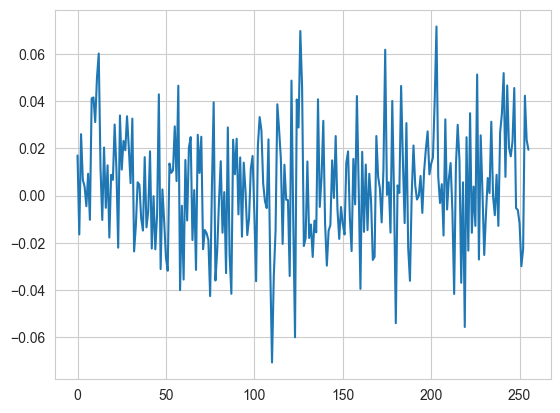

In [19]:
plt.plot(style_embedding[0].detach().numpy())

In [ ]:
from transformers import AutoModelForCausalLM
from PIL import Image
import torch

# Set the device to GPU if available, else fallback to MPS or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# Load the model and move it to the selected device
model = AutoModelForCausalLM.from_pretrained(
    "vikhyatk/moondream2",
    revision="2025-01-09",
    trust_remote_code=True,
)

model = model.to(device)

# Open the image and also move it to the same device
image = Image.open('/Users/hoangthuyduongvu/Documents/icm/tumor-augmentation/data/train/REAL/0000 (4).jpg')

# Assuming the model.encode_image method handles image tensor transformation,
# make sure that the image is passed correctly to the model
enc_image = model.encode_image(image)

# Now, you can query the model for the description
print(model.query(enc_image, "Describe this image."))
